In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import accuracy_score
from keras import backend as K

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [23]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
del y_train, y_test

In [103]:
print(np.mean(X_train).round())
print(X_train.shape)
print(X_test.shape)

73.0
(60000, 28, 28)
(10000, 28, 28)


C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


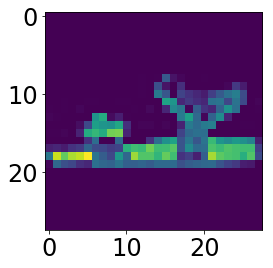

In [104]:
plt.imshow(X_train[59999].reshape([28,28]))

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


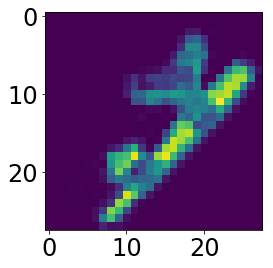

In [105]:
plt.imshow(transform.rotate(X_train[59999].reshape([28,28]), 45))

### Задание.
Ваша задача - определить, при каком минимальном угле поворота нейронная сеть фиксированной архитектуры перестает различать обычное и повертнутое изображение. Говоря формально, решаем задачу классификации, исходные изображения принадлежат классу `0`, повернутые - классу `1`. Оцените точность классификации по метрике `accuracy` и ее дисперсию в зависимости от угла поворота изображения и отобразите данную зависимость на графике.

Функция `rotate_dataset` поворачивает поданный датасет на заданный угол. Функция `reset_weights` сбрасывает параметры модели.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [25]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

In [18]:
def get_X_and_y(base_dataset, angle):
    rotated_datased = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((base_dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    
    np.random.shuffle(shuffled_indices)    
    whole_dataset = whole_dataset[shuffled_indices]
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


In [19]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

In [20]:
# compile the net itself
def compile_model():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer([784]))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Activation('softmax'))
    model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# set hyper parameters
batch_size = 128
nb_epochs = 40
N = 500  # number of samples in training dataset
nb_runs = 8  # number of times the net is trained and predictions are made for each angle

In [111]:
def count_scores(start, end, angle_step, verbose = False):
    model = compile_model()
    scores=[]  # mean scores for "nb_runs" runs
    for angle in range(start, end, angle_step):
        run_score = []  # score for one run
        X_test_whole, y_test_whole = get_X_and_y(X_test, angle)
        # run several times with different samples chosen for training
        for nrun in range(nb_runs):
            # indices that are used for picking training samples out of X_train
            base_indices = np.random.choice(np.arange(X_train.shape[0]), 
                                            size=N, replace=False)
            # training dataset
            base_dataset = X_train[base_indices].reshape([-1, 28,28]) / 255
            X, y = get_X_and_y(base_dataset, angle)
            # training itself
            model.fit(X, y, batch_size=batch_size, epochs=nb_epochs, verbose=0)
            # get predictions on test data
            y_test_predicted_whole = model.predict_classes(X_test_whole / 255)
            run_score.append(accuracy_score(y_test_whole[:, 1], y_test_predicted_whole))
            if verbose:
                print('angle={1}, run={2}/{3}'.format(N, angle, nrun+1, nb_runs))
                print("Accuracy: {0}".format(run_score[-1]))
            reset_weights(model)
        # save mean score and its standard deviation for each angle
        scores.append([angle, np.mean(run_score), np.std(run_score)])
    return scores

In [112]:
scores = count_scores(0, 361, 30, True)
np.save('scores.npy', scores)

angle=0, run=1/8
Accuracy: 0.47495
angle=0, run=2/8
Accuracy: 0.4758
angle=0, run=3/8
Accuracy: 0.53645
angle=0, run=4/8
Accuracy: 0.56275
angle=0, run=5/8
Accuracy: 0.5887
angle=0, run=6/8
Accuracy: 0.4425
angle=0, run=7/8
Accuracy: 0.56125
angle=0, run=8/8
Accuracy: 0.6595
angle=30, run=1/8
Accuracy: 0.9966
angle=30, run=2/8
Accuracy: 0.99755
angle=30, run=3/8
Accuracy: 0.99535
angle=30, run=4/8
Accuracy: 0.99645
angle=30, run=5/8
Accuracy: 0.99535
angle=30, run=6/8
Accuracy: 0.9947
angle=30, run=7/8
Accuracy: 0.996
angle=30, run=8/8
Accuracy: 0.9962
angle=60, run=1/8
Accuracy: 0.99635
angle=60, run=2/8
Accuracy: 0.9974
angle=60, run=3/8
Accuracy: 0.9967
angle=60, run=4/8
Accuracy: 0.9974
angle=60, run=5/8
Accuracy: 0.99635
angle=60, run=6/8
Accuracy: 0.9946
angle=60, run=7/8
Accuracy: 0.99485
angle=60, run=8/8
Accuracy: 0.99565
angle=90, run=1/8
Accuracy: 0.9807
angle=90, run=2/8
Accuracy: 0.98355
angle=90, run=3/8
Accuracy: 0.9819
angle=90, run=4/8
Accuracy: 0.987
angle=90, run=5/8

In [113]:
scores = np.load('scores.npy') 

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


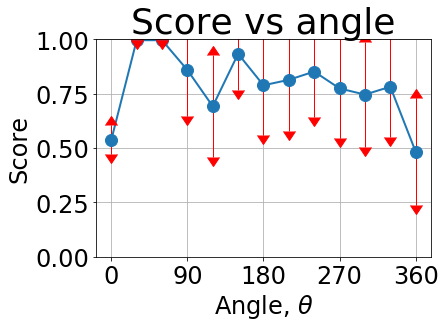

In [114]:
# plot graph score vs angle in 0 - 360 degree range
fig, ax1 = plt.subplots(1, 1)
ax1.set_title('Score vs angle')
ax1.set_xlabel(r'Angle, $\theta$')
ax1.set_ylabel(r'Score')

scores = np.array(scores)
plt.plot(scores[:, 0], scores[:, 1], '-o')
ax1.errorbar(scores[:, 0], scores[:, 1], yerr=scores[:, 2], fmt='none', color="red", elinewidth=1, uplims=True, lolims=True)
ax1.set_xticks(np.arange(0, 361, 90))
ax1.set_ylim(0, 1)
ax1.grid()

plt.savefig('score_v_angle_[0-360].png')
plt.show()

Как видно из графика, точность классификации почти не зависит от угла поворота, если он отличается более чем на 10 градусов от 0 или 360. Поэтому рассмотрим подробнее случаи с малыми поворотами - не более 10 градусов.

In [115]:
first_scores = count_scores(0, 11, 1, True)
np.save('first_scores.npy', first_scores)

angle=0, run=1/8
Accuracy: 0.3869
angle=0, run=2/8
Accuracy: 0.2708
angle=0, run=3/8
Accuracy: 0.5227
angle=0, run=4/8
Accuracy: 0.32425
angle=0, run=5/8
Accuracy: 0.31005
angle=0, run=6/8
Accuracy: 0.2354
angle=0, run=7/8
Accuracy: 0.46665
angle=0, run=8/8
Accuracy: 0.7869
angle=1, run=1/8
Accuracy: 0.7377
angle=1, run=2/8
Accuracy: 0.8192
angle=1, run=3/8
Accuracy: 0.73495
angle=1, run=4/8
Accuracy: 0.7742
angle=1, run=5/8
Accuracy: 0.8436
angle=1, run=6/8
Accuracy: 0.86225
angle=1, run=7/8
Accuracy: 0.73855
angle=1, run=8/8
Accuracy: 0.7807
angle=2, run=1/8
Accuracy: 0.8046
angle=2, run=2/8
Accuracy: 0.804
angle=2, run=3/8
Accuracy: 0.8601
angle=2, run=4/8
Accuracy: 0.7491
angle=2, run=5/8
Accuracy: 0.80945
angle=2, run=6/8
Accuracy: 0.8842
angle=2, run=7/8
Accuracy: 0.86455
angle=2, run=8/8
Accuracy: 0.86735
angle=3, run=1/8
Accuracy: 0.9085
angle=3, run=2/8
Accuracy: 0.85785
angle=3, run=3/8
Accuracy: 0.8881
angle=3, run=4/8
Accuracy: 0.9009
angle=3, run=5/8
Accuracy: 0.8949
angle

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


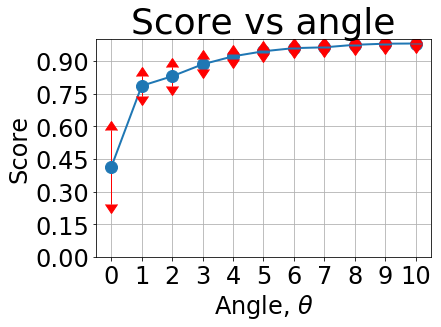

In [116]:
# plot graph score vs angle in 0 - 10 degree range
first_scores = np.load('first_scores.npy') 

fig, ax2 = plt.subplots(1, 1)
ax2.set_title('Score vs angle')
ax2.set_xlabel(r'Angle, $\theta$')
ax2.set_ylabel(r'Score')

scores = np.array(first_scores)
plt.plot(scores[:, 0], scores[:, 1], '-o')
ax2.errorbar(scores[:, 0], scores[:, 1], yerr=scores[:, 2], fmt='none', color="red", elinewidth=1, uplims=True, lolims=True)
ax2.set_xticks(np.arange(0, 11, 1))
ax2.set_yticks(np.arange(0, 1, 0.15))
ax2.set_ylim(0, 1)
ax2.grid()

plt.savefig('score_v_angle_[0-10].png')
plt.show()

При отсутствии поворота (повороте 0 или 360 градусов) классифицировать не имеет смысла. При повороте на углы кратные 90 точность классификации незначительно падает на 2-3 процента.
Минимальный угол поворота при котором нейронная сеть определяет, повернуто ли изображение - 3 градуса (при меньших углах точность падает ниже 90 процентов).

Теперь для пограничного угла поворота (3 градуса) построим график зависимости значения ошибки и его стандартного отклонения от объема выборки на обучении и контроле.

In [14]:
# n_tr -  number of images in train dataset, n_ts - numbers of images in test dataset
def count_score(angle, n_tr, n_ts, verbose = False):
    model = compile_model()
    run_score = []  # score for one run
    X_test_whole, y_test_whole = get_X_and_y(X_test, angle)
    # run several times with different samples chosen for training
    for nrun in range(nb_runs):
        # indices that are used for picking training samples out of X_train
        base_indices = np.random.choice(np.arange(X_train.shape[0]), 
                                        size=n_tr, replace=False)
        # training dataset ("/255" for making initial images have same pixel value magnitude)
        base_dataset = X_train[base_indices].reshape([-1, 28,28]) / 255
        X, y = get_X_and_y(base_dataset, angle)
        # training itself
        model.fit(X, y, batch_size=batch_size, epochs=nb_epochs, verbose=0)
        # get predictions on test data
        # indices that are used for picking samples for validation out of X_test_whole
        test_indices = np.random.choice(np.arange(X_test_whole.shape[0]), 
                                        size=n_ts, replace=False)
        X_test_dataset = X_test_whole[test_indices].reshape([-1, 784]) / 255
        y_test_dataset = y_test_whole[test_indices]
        y_test_predicted_whole = model.predict_classes(X_test_dataset)
        run_score.append(accuracy_score(y_test_dataset[:, 1], y_test_predicted_whole))
        if verbose:
            print('angle={1}, run={2}/{3}'.format(N, angle, nrun+1, nb_runs))
            print("Accuracy: {0}, n_tr: {1}, n_ts: {2}".format(run_score[-1], n_tr, n_ts))
        reset_weights(model)
    print("Average accuracy: {0}, std: {1}, n_tr: {2}, n_ts: {3}".format(np.mean(run_score).round(3), np.std(run_score).round(3),
                                                                         n_tr, n_ts))
    return np.mean(run_score).round(2), np.std(run_score).round(3)

In [26]:
points = []
angle = 3
training_dataset_lengths = [500, 1000, 2000, 5000, 10000]
test_dataset_lengths = [500, 1000, 2000, 5000, 10000]
# training_dataset_lengths = [500, 1000]
# test_dataset_lengths = [500, 1000]
for n_ts in training_dataset_lengths:
    for n_tr in training_dataset_lengths:
        score, std = count_score(angle, n_tr, n_ts, False)
        points.append([angle, n_tr, n_ts, score, std])
np.save('points.npy', points)

Average accuracy: 0.9005, std: 0.025, n_tr: 500, n_ts: 500
Average accuracy: 0.9232499999999999, std: 0.025, n_tr: 1000, n_ts: 500
Average accuracy: 0.9215000000000001, std: 0.015, n_tr: 2000, n_ts: 500
Average accuracy: 0.9524999999999999, std: 0.009, n_tr: 5000, n_ts: 500
Average accuracy: 0.96175, std: 0.012, n_tr: 10000, n_ts: 500
Average accuracy: 0.899125, std: 0.017, n_tr: 500, n_ts: 1000
Average accuracy: 0.9108750000000001, std: 0.011, n_tr: 1000, n_ts: 1000
Average accuracy: 0.926375, std: 0.015, n_tr: 2000, n_ts: 1000
Average accuracy: 0.94675, std: 0.004, n_tr: 5000, n_ts: 1000
Average accuracy: 0.964625, std: 0.008, n_tr: 10000, n_ts: 1000
Average accuracy: 0.8945000000000001, std: 0.022, n_tr: 500, n_ts: 2000
Average accuracy: 0.9164375, std: 0.016, n_tr: 1000, n_ts: 2000
Average accuracy: 0.9260625, std: 0.011, n_tr: 2000, n_ts: 2000
Average accuracy: 0.9436875, std: 0.012, n_tr: 5000, n_ts: 2000
Average accuracy: 0.9600625, std: 0.007, n_tr: 10000, n_ts: 2000
Average ac

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


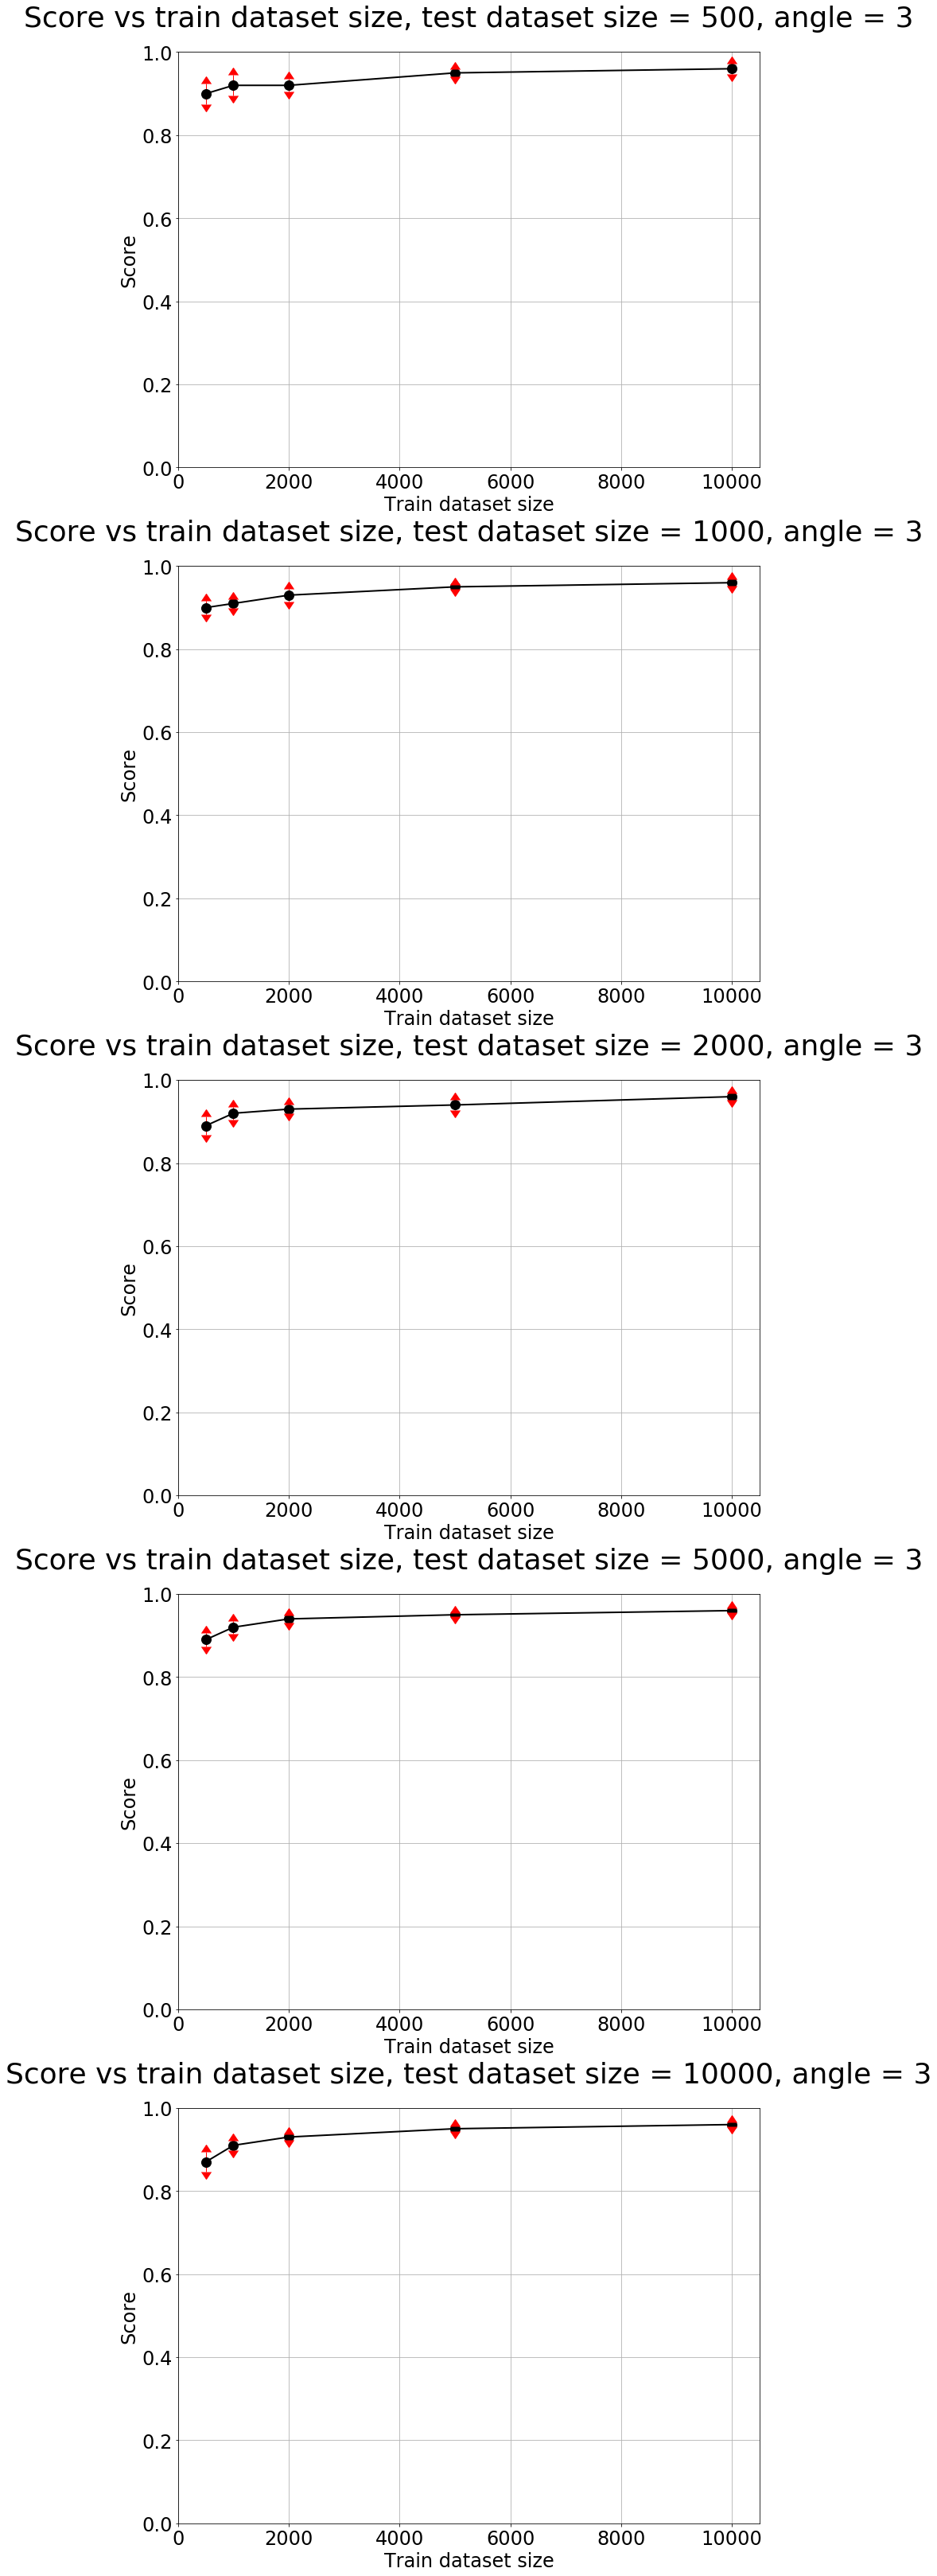

In [28]:
training_dataset_lengths = [500, 1000, 2000, 5000, 10000]
test_dataset_lengths = [500, 1000, 2000, 5000, 10000]
points = np.load('points.npy')  
n_train = []  # numbers of images in train dataset
n_test = []  # numbers of images in validation dataset
fix_scores = []  # score for various dataset sizes
fix_std = []  # deviation for various dataset size
n = len(test_dataset_lengths)  # number of different volumes of test datasets
m = len(training_dataset_lengths)  # number of different volumes of training datasets

# convert list of lists to separate lists before plotting
for k, _list in enumerate(points):
    n_train.append(_list[1])
    fix_scores.append(_list[3])
    fix_std.append(_list[4])
    
angle = points[0][0]


fig3, ax = plt.subplots(n, 1, figsize=(15,9*n), squeeze=False)


for i in range(n):
    ttl = ax[i,0].title
    ttl.set_position([.5, 1.05])
    ax[i,0].set_title('Score vs train dataset size, test dataset size = {0}, angle = {1}'.format
                      (test_dataset_lengths[i], int(angle)))
    ax[i,0].set_xlabel(r'Train dataset size')
    ax[i,0].set_ylabel(r'Score')

    start = int(i*m)
    end = int((i+1)*m)
    ax[i,0].plot(training_dataset_lengths, fix_scores[start: end], '-o', color="black")
    ax[i,0].errorbar(training_dataset_lengths, fix_scores[start:end], 
                     yerr=fix_std[start:end], fmt='none', color="red", elinewidth=1, uplims=True, lolims=True)
    ax[i,0].set_ylim(0,1)
    ax[i,0].grid()

    ax[i,0].set_xlim(0, np.min(training_dataset_lengths) + np.max(training_dataset_lengths))

fig3.tight_layout()

plt.savefig('ModelFashion.png')

plt.show()